In [1]:
# Initiializations and inputs
import matplotlib.pyplot as plt 
import os
from os.path import join
import numpy as np
from PIL import Image
import matplotlib.image as mpimg 
from skimage.color import rgb2gray 
from skimage.color import label2rgb 
from skimage.filters import gaussian 
from sklearn.cluster import KMeans
from skimage import filters



plt.close('all')
clear = lambda: os.system('clear') 
clear()
np.random.seed(110)

colors = [[1,0,0],[0,1,0],[0,0,1],[0,0.5,0.5],[0.5,0,0.5]]

imgNames = ['water_coins','jump','tiger']   #{'balloons', 'mountains', 'nature', 'ocean', 'polarlights'};
segmentCounts = [2,3,4,5]

In [2]:
# Define functions required for processing [unused in code]
def normalize(img):
    """ min-max normalization """
    h = img.shape[0]
    w = img.shape[1]
    nc = img.shape[2]
    new_img = np.zeros((h,w,nc),dtype='float') 
    for cc in range(nc):
        new_img[:,cc] = (img[:,cc] - img[:,cc].min()) / (img[:,cc].max() - img[: ,cc].min())
        return(new_img)
    
    def im2double(im): 
        try:
            info = np.iinfo(im.dtype) # Get the data type of the input image
            return im.astype(np.float) / info.max # Divide all values by the largest possible value in the datatype
        except ValueError:
            print('Image is of type Double-- No conversion required') 
            return im.astype(np.float)

In [3]:
for imgName in imgNames:
    for SegCount in segmentCounts:
        
        # Loading the image using the Matplotlib image library.
        # Images are in the 'Input' directory. Use 'join' command to include folder
        
        # Path to access image file
        img_path = join('Input', imgName + '.png')

        """ Reading the Image using mplib library-- 2 points """
        img = mpimg.imread(img_path)
        print('Using Matplotlib Image Library: Image is of datatype ',img.dtype,' and size ',img.shape) # Image is of type float

        # Load image using the Pillow or the Python Imaging Library
        """ Read Image using PILLOW-- 3 points"""
        img = Image.open(img_path)
        img = np.array(img)
        print('Using Pillow Image Library: Image is of datatype ',img.dtype,' and size ',img.shape) # Image is of type uint8

        #%% %Define Parameters
        nSegments = SegCount    # of color clusters in image

        """ Compute number of image pixels from image dimensions-- 2-points"""
        nPixels = img.shape[0] * img.shape[1]

        # Image can be represented by a matrix of size nPixels*nColors
        maxIterations = 20  #maximum number of iterations allowed for EM algorithm.
        nColors = 3

        #%% Determine the output path for writing images to files
        outputPath = join(''.join(['Output/',str(SegCount), '_segments/', imgName , '/']))
        if not(os.path.exists(outputPath)):
            os.makedirs(outputPath)


        """ save input image as *0.png* under outputPath using imsave command in mpimg library-- 3 points""" 
        # Saving image using Matplotlib image library
        mpimg.imsave(join(outputPath, '0.png'), img)

        # Vectorizing image for easier loops- done as im(:) in Matlab
        pixels = img
        """ Reshape pixels as a nPixels X nColors X 1 matrix-- 5 points"""
        pixels = pixels.reshape(nPixels, nColors, 1)

        #%%
        """ Initialize pi (mixture proportion) vector and mu matrix (containing means of each distribution)
            Vector of probabilities for segments... 1 value for each segment.
            The idea behind image generation goes like this- When the image was generated, color was determined for each pixel by selecting a value from one of "n" normal distributions
            corresponding to the "n" color segments. Each value in this vector corresponds to the probability that a particular segment or normal distribution was chosen.
        """


        """ Initial guess for pi's is 1/nSegments. Small amount of noise added to slightly perturb GMM coefficients from the initial guess"""
        pi = 1/nSegments*(np.ones((nSegments, 1),dtype='float'))
        increment = np.random.normal(0,.0001,1)

        for seg_ctr in range(len(pi)):
            if(seg_ctr%2==1):
                pi[seg_ctr] = pi[seg_ctr] + increment
            else:
                pi[seg_ctr] = pi[seg_ctr] - increment

        #%%    
        """Similarly, the initial guess for the segment color means would be a perturbed version of [mu_R, mu_G, mu_B],
            where mu_R, mu_G, mu_B respectively denote the means of the R,G,B color channels in the image.
            mu is a nSegments X nColors matrix,(seglabels*255).np.asarray (in int format) where each matrix row denotes mean RGB color for a particular segment
        """

        """Initialize mu to 1/nSegments*['ones' matrix(whose elements are all 1) of size nSegments X nColors] --5 points""" 
        mu = 1 / nSegments*(np.ones((nSegments, nColors), dtype='int'))

       #add noise to the initialization (but keep it unit)
        for seg_ctr in range(nSegments):
            if(seg_ctr%2==1):
                increment = np.random.normal(0,.0001,1)
            for col_ctr in range(nColors):
                if(seg_ctr%2==1):
                    mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) + increment
                else:
                    mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) - increment

        #%% EM-iterations begin here. Start with the initial (pi, mu) guesses
        mu_last_iter = mu
        pi_last_iter = pi

        for iteration in range(maxIterations):
            """%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                ----------------------------------------- E-step -----------------------------------------
                                    estimating likelihoods and membership weights (Ws)
            %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%"""

            print(''.join(['Image: ',imgName,' with nSegments = ',str(nSegments), ' on iteration = ',str(iteration+1), ' - E-step']))
            
            # Weights that describe the likelihood that pixel denoted by "pix_import scipy.miscctr" belongs to a color cluster "seg_ctr"
            Ws = np.ones((nPixels,nSegments),dtype='float') # temporarily reinitialize all weights to 1, before they are recomputed
            
            """ Logarithmic form of the E step """
            for pix_ctr in range(nPixels):
                # Calculate Ajs
                logAjVec = np.zeros((nSegments,1),dtype='float')
                for seg_ctr in range(nSegments):
                    x_minus_mu_T = np.transpose(pixels[pix_ctr,:]-(mu[seg_ctr,:])[np.newaxis].T)
                    x_minus_mu = ((pixels[pix_ctr,:]-(mu[seg_ctr,:])[np.newaxis].T))
                    logAjVec[seg_ctr] = np.log(pi[seg_ctr]) - .5*(np.dot(x_minus_mu_T,x_minus_mu))
                
                # Note the max
                logAmax = max(logAjVec.tolist())
            
                # Calculate the third term from the final eqn in the above link
                thirdTerm = 0
                for seg_ctr in range(nSegments):
                    thirdTerm = thirdTerm + np.exp(logAjVec[seg_ctr]-logAmax)  

                # Here Ws are the relative membership weights(p_i/sum(p_i)),but computed in a round-about way
                for seg_ctr in range(nSegments):
                    logY = logAjVec[seg_ctr] - logAmax - np.log(thirdTerm)
                    Ws[pix_ctr][seg_ctr] = np.exp(logY)     

            """%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                ----------------------------------------- M-step -----------------------------------------
            %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%"""

            print(''.join(['Image: ',imgName,' with nSegments: ',str(nSegments),' on iteration: ',str(iteration+1), ' - M-step: Mixture coefficients']))
            
            #%% temporarily reinitialize mu and pi to 0, before they are recomputed
            mu = np.zeros((nSegments,nColors),dtype='float') # mean color for each segment
            pi = np.zeros((nSegments,1),dtype='float') #mixture coefficients

            for seg_ctr in range(nSegments): 

                '''denominatorSum = 0
                for pix_ctr in range(nPixels):
                    """Update RGB color vector of mu[seg_ctr] as current mu[seg_ctr] + pixels[pix_ctr,:] times Ws[pix_ctr,seg_ctr] -- 5 points"""
                    mu[seg_ctr] += pixels[pix_ctr, :] * Ws[pix_ctr, seg_ctr]

                    denominatorSum = denominatorSum + Ws[pix_ctr, seg_ctr]'''
                # For loop commented out as denominatorSum and mu[seg_ctr] are calculated without the loop

                """Compute mu[seg_ctr] and denominatorSum directly without the 'for loop'-- 10 points.
                    If you find the replacement instruction, comment out the for loop with your solution
                    Hint: Use functions squeeze, tile and reshape along with sum"""
                
                mu[seg_ctr] = np.reshape(np.dot( np.transpose(np.squeeze(pixels)) , Ws[:,seg_ctr] ), (nColors,))   
                denominatorSum = np.sum(Ws[:,seg_ctr])
               
                ## Update mu
                mu[seg_ctr,:] = mu[seg_ctr,:]/ denominatorSum
                ## Update pi
                pi[seg_ctr] = denominatorSum / nPixels #sum of weights (each weight is a probability) for given segment/total num of pixels

            print(np.transpose(pi))
            muDiffSq = np.sum(np.multiply((mu - mu_last_iter),(mu - mu_last_iter)))
            piDiffSq = np.sum(np.multiply((pi - pi_last_iter),(pi - pi_last_iter)))

            if (muDiffSq < .0000001 and piDiffSq < .0000001): #sign of convergence
                print('Convergence Criteria Met at Iteration: ',iteration, '--Exiting code\n')
                break
                    
            mu_last_iter = mu   
            pi_last_iter = pi

            ##Draw the segmented image using the  mean of the color cluster as the RGB value for all pixels in that cluster.
            
            segpixels = np.array(pixels)
            cluster = 0
            for pix_ctr in range(nPixels):
                cluster = np.where(Ws[pix_ctr,:] == max(Ws[pix_ctr,:]))
                vec = np.squeeze(np.transpose(mu[cluster,:]))
                segpixels[pix_ctr,:] = vec.reshape(vec.shape[0],1)

            """ Save segmented image at each iteration. 
                For displaying consistent image clusters, it would be useful to blur/smoothen the segpixels image using a Gaussian filter. 
                Prior to smoothing, convert segpixels to a Grayscale image, and convert the grayscale image into clusters based on pixel intensities"""

            # Assigning each pixel to the segment with the highest probability
            seglabels = np.argmax(Ws, axis=1) 
            # Reshaping segpixels to obtain R,G,B image
            segpixels = np.reshape(segpixels,(img.shape[0],img.shape[1],nColors))
            
            """ Convert segpixels to uint8 gray scale image and convert to grayscale-- 5 points"""       
            # Converting to grayscale  
            segpixels = rgb2gray(segpixels.astype(np.uint8))
            
            """ Use kmeans from sci-kit learn library to cluster pixels in gray scale segpixels image to *nSegments* cluster-- 10 points"""   
            kmeans = KMeans(n_clusters = nSegments).fit(np.reshape(segpixels, (nPixels, 1)))
            
            """ Reshape kmeans.labels_ output by kmeans to have the same size as segpixels -- 5 points"""
            seglabels = np.reshape(np.array(kmeans.labels_, dtype=np.uint8), (segpixels.shape[0], segpixels.shape[1]))   
    
            """ Use np.clip, Gaussian smoothing with sigma = 2 and label2rgb functions to smoothen the seglabels image, 
                and output a float RGB image with pixel values between [0--1]-- 20 points"""
            # Converting the segmented labels to a color image
            seglabels = label2rgb(seglabels)
            # Smoothening color image and clipping it to [0,1] pixel values
            seglabels = gaussian(np.clip(seglabels, 0, 1), sigma=2)
            
            # Saving the segmented output
            mpimg.imsave(''.join([outputPath,str(iteration + 1),'.png']),seglabels)

    """ Display the 20th iteration (or final output in case of convergence) segmentation images 
    with nSegments = 2,3,4,5 for the three images-- this will be a 3 row X 4 column image matrix-- 15 points """ 
    # DONE IN THE NEXT CODE CELL

Using Matplotlib Image Library: Image is of datatype  float32  and size  (312, 252, 3)
Using Pillow Image Library: Image is of datatype  uint8  and size  (312, 252, 3)
Image: water_coins with nSegments = 2 on iteration = 1 - E-step
Image: water_coins with nSegments: 2 on iteration: 1 - M-step: Mixture coefficients
[[0.49996714 0.50003286]]
Image: water_coins with nSegments = 2 on iteration = 2 - E-step
Image: water_coins with nSegments: 2 on iteration: 2 - M-step: Mixture coefficients
[[0.44622235 0.55377765]]
Image: water_coins with nSegments = 2 on iteration = 3 - E-step
Image: water_coins with nSegments: 2 on iteration: 3 - M-step: Mixture coefficients
[[0.44233313 0.55766687]]
Image: water_coins with nSegments = 2 on iteration = 4 - E-step
Image: water_coins with nSegments: 2 on iteration: 4 - M-step: Mixture coefficients
[[0.4420263 0.5579737]]
Image: water_coins with nSegments = 2 on iteration = 5 - E-step
Image: water_coins with nSegments: 2 on iteration: 5 - M-step: Mixture coe

/Users/omishan/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Image: water_coins with nSegments = 3 on iteration = 2 - E-step
Image: water_coins with nSegments: 3 on iteration: 2 - M-step: Mixture coefficients
[[0.44599643 0.00064829 0.55335528]]
Image: water_coins with nSegments = 3 on iteration = 3 - E-step
Image: water_coins with nSegments: 3 on iteration: 3 - M-step: Mixture coefficients
[[0.42073562 0.04230984 0.53695454]]
Image: water_coins with nSegments = 3 on iteration = 4 - E-step
Image: water_coins with nSegments: 3 on iteration: 4 - M-step: Mixture coefficients
[[0.41511536 0.04621985 0.53866479]]
Image: water_coins with nSegments = 3 on iteration = 5 - E-step
Image: water_coins with nSegments: 3 on iteration: 5 - M-step: Mixture coefficients
[[0.41244404 0.04739029 0.54016568]]
Image: water_coins with nSegments = 3 on iteration = 6 - E-step
Image: water_coins with nSegments: 3 on iteration: 6 - M-step: Mixture coefficients
[[0.41064442 0.04823772 0.54111786]]
Image: water_coins with nSegments = 3 on iteration = 7 - E-step
Image: wate

/Users/omishan/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Image: water_coins with nSegments = 4 on iteration = 2 - E-step
Image: water_coins with nSegments: 4 on iteration: 2 - M-step: Mixture coefficients
[[0.00090989 0.00060194 0.44556736 0.5529208 ]]
Image: water_coins with nSegments = 4 on iteration = 3 - E-step
Image: water_coins with nSegments: 4 on iteration: 3 - M-step: Mixture coefficients
[[0.02638862 0.01662421 0.42017907 0.5368081 ]]
Image: water_coins with nSegments = 4 on iteration = 4 - E-step
Image: water_coins with nSegments: 4 on iteration: 4 - M-step: Mixture coefficients
[[0.03762229 0.02333574 0.40749645 0.53154553]]
Image: water_coins with nSegments = 4 on iteration = 5 - E-step
Image: water_coins with nSegments: 4 on iteration: 5 - M-step: Mixture coefficients
[[0.04261739 0.02650524 0.40099167 0.52988569]]
Image: water_coins with nSegments = 4 on iteration = 6 - E-step
Image: water_coins with nSegments: 4 on iteration: 6 - M-step: Mixture coefficients
[[0.04507475 0.02781508 0.39727106 0.52983911]]
Image: water_coins w

/Users/omishan/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Image: water_coins with nSegments = 5 on iteration = 2 - E-step
Image: water_coins with nSegments: 5 on iteration: 2 - M-step: Mixture coefficients
[[4.61769027e-04 3.37304766e-04 3.76967376e-04 4.45566939e-01
  5.53257020e-01]]
Image: water_coins with nSegments = 5 on iteration = 3 - E-step
Image: water_coins with nSegments: 5 on iteration: 3 - M-step: Mixture coefficients
[[0.02616001 0.00058942 0.01654525 0.41970645 0.53699888]]
Image: water_coins with nSegments = 5 on iteration = 4 - E-step
Image: water_coins with nSegments: 5 on iteration: 4 - M-step: Mixture coefficients
[[0.03361366 0.01018597 0.01756172 0.40699374 0.5316449 ]]
Image: water_coins with nSegments = 5 on iteration = 5 - E-step
Image: water_coins with nSegments: 5 on iteration: 5 - M-step: Mixture coefficients
[[0.03795748 0.0163938  0.02041222 0.39834688 0.52688961]]
Image: water_coins with nSegments = 5 on iteration = 6 - E-step
Image: water_coins with nSegments: 5 on iteration: 6 - M-step: Mixture coefficients
[[

/Users/omishan/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Image: jump with nSegments = 4 on iteration = 2 - E-step
Image: jump with nSegments: 4 on iteration: 2 - M-step: Mixture coefficients
[[0.61900879 0.0082674  0.00485835 0.36786547]]
Image: jump with nSegments = 4 on iteration = 3 - E-step
Image: jump with nSegments: 4 on iteration: 3 - M-step: Mixture coefficients
[[0.5097863  0.0693002  0.20390449 0.21700901]]
Image: jump with nSegments = 4 on iteration = 4 - E-step
Image: jump with nSegments: 4 on iteration: 4 - M-step: Mixture coefficients
[[0.4404684  0.14648112 0.2354598  0.17759068]]
Image: jump with nSegments = 4 on iteration = 5 - E-step
Image: jump with nSegments: 4 on iteration: 5 - M-step: Mixture coefficients
[[0.40350832 0.19183825 0.22986924 0.17478419]]
Image: jump with nSegments = 4 on iteration = 6 - E-step
Image: jump with nSegments: 4 on iteration: 6 - M-step: Mixture coefficients
[[0.36219769 0.24166607 0.22152187 0.17461437]]
Image: jump with nSegments = 4 on iteration = 7 - E-step
Image: jump with nSegments: 4 on 

/Users/omishan/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Image: jump with nSegments = 5 on iteration = 2 - E-step
Image: jump with nSegments: 5 on iteration: 2 - M-step: Mixture coefficients
[[0.36482216 0.15613964 0.0044602  0.47003258 0.00454541]]


/Users/omishan/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Image: jump with nSegments = 5 on iteration = 3 - E-step
Image: jump with nSegments: 5 on iteration: 3 - M-step: Mixture coefficients
[[0.21584209 0.1870128  0.14384266 0.3585492  0.09475324]]
Image: jump with nSegments = 5 on iteration = 4 - E-step
Image: jump with nSegments: 5 on iteration: 4 - M-step: Mixture coefficients
[[0.17470283 0.25724002 0.14383895 0.2981411  0.12607711]]
Image: jump with nSegments = 5 on iteration = 5 - E-step
Image: jump with nSegments: 5 on iteration: 5 - M-step: Mixture coefficients
[[0.17204154 0.28805318 0.16975143 0.26066919 0.10948466]]
Image: jump with nSegments = 5 on iteration = 6 - E-step
Image: jump with nSegments: 5 on iteration: 6 - M-step: Mixture coefficients
[[0.17173441 0.34057369 0.18733989 0.20338201 0.09697   ]]
Image: jump with nSegments = 5 on iteration = 7 - E-step
Image: jump with nSegments: 5 on iteration: 7 - M-step: Mixture coefficients
[[0.1715256  0.39221513 0.20263253 0.1461099  0.08751684]]
Image: jump with nSegments = 5 on i

/Users/omishan/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Image: tiger with nSegments = 3 on iteration = 2 - E-step
Image: tiger with nSegments: 3 on iteration: 2 - M-step: Mixture coefficients
[[0.60006137 0.37214009 0.02779854]]
Image: tiger with nSegments = 3 on iteration = 3 - E-step
Image: tiger with nSegments: 3 on iteration: 3 - M-step: Mixture coefficients
[[0.44168753 0.25003589 0.30827658]]
Image: tiger with nSegments = 3 on iteration = 4 - E-step
Image: tiger with nSegments: 3 on iteration: 4 - M-step: Mixture coefficients
[[0.41517136 0.21062803 0.37420061]]
Image: tiger with nSegments = 3 on iteration = 5 - E-step
Image: tiger with nSegments: 3 on iteration: 5 - M-step: Mixture coefficients
[[0.41808305 0.19663779 0.38527916]]
Image: tiger with nSegments = 3 on iteration = 6 - E-step
Image: tiger with nSegments: 3 on iteration: 6 - M-step: Mixture coefficients
[[0.42686621 0.19073731 0.38239648]]
Image: tiger with nSegments = 3 on iteration = 7 - E-step
Image: tiger with nSegments: 3 on iteration: 7 - M-step: Mixture coefficients

/Users/omishan/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Image: tiger with nSegments = 4 on iteration = 2 - E-step
Image: tiger with nSegments: 4 on iteration: 2 - M-step: Mixture coefficients
[[0.60358999 0.0182659  0.01733419 0.36080992]]
Image: tiger with nSegments = 4 on iteration = 3 - E-step
Image: tiger with nSegments: 4 on iteration: 3 - M-step: Mixture coefficients
[[0.4605374  0.15725963 0.14375429 0.23844868]]
Image: tiger with nSegments = 4 on iteration = 4 - E-step
Image: tiger with nSegments: 4 on iteration: 4 - M-step: Mixture coefficients
[[0.37939415 0.24889358 0.18125115 0.19046112]]
Image: tiger with nSegments = 4 on iteration = 5 - E-step
Image: tiger with nSegments: 4 on iteration: 5 - M-step: Mixture coefficients
[[0.3322752  0.31000612 0.18880388 0.1689148 ]]
Image: tiger with nSegments = 4 on iteration = 6 - E-step
Image: tiger with nSegments: 4 on iteration: 6 - M-step: Mixture coefficients
[[0.30417161 0.34943778 0.18868024 0.15771037]]
Image: tiger with nSegments = 4 on iteration = 7 - E-step
Image: tiger with nSeg

/Users/omishan/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Image: tiger with nSegments = 5 on iteration = 2 - E-step
Image: tiger with nSegments: 5 on iteration: 2 - M-step: Mixture coefficients
[[0.02802549 0.3449312  0.61280616 0.00678229 0.00745486]]
Image: tiger with nSegments = 5 on iteration = 3 - E-step
Image: tiger with nSegments: 5 on iteration: 3 - M-step: Mixture coefficients
[[0.13030283 0.2239964  0.46551676 0.02806432 0.15211971]]
Image: tiger with nSegments = 5 on iteration = 4 - E-step
Image: tiger with nSegments: 5 on iteration: 4 - M-step: Mixture coefficients
[[0.14250896 0.18117798 0.37990441 0.08650666 0.20990198]]
Image: tiger with nSegments = 5 on iteration = 5 - E-step
Image: tiger with nSegments: 5 on iteration: 5 - M-step: Mixture coefficients
[[0.14552718 0.15913828 0.32456979 0.11504242 0.25572234]]
Image: tiger with nSegments = 5 on iteration = 6 - E-step
Image: tiger with nSegments: 5 on iteration: 6 - M-step: Mixture coefficients
[[0.14435434 0.14642544 0.27995509 0.13418364 0.29508149]]
Image: tiger with nSegmen

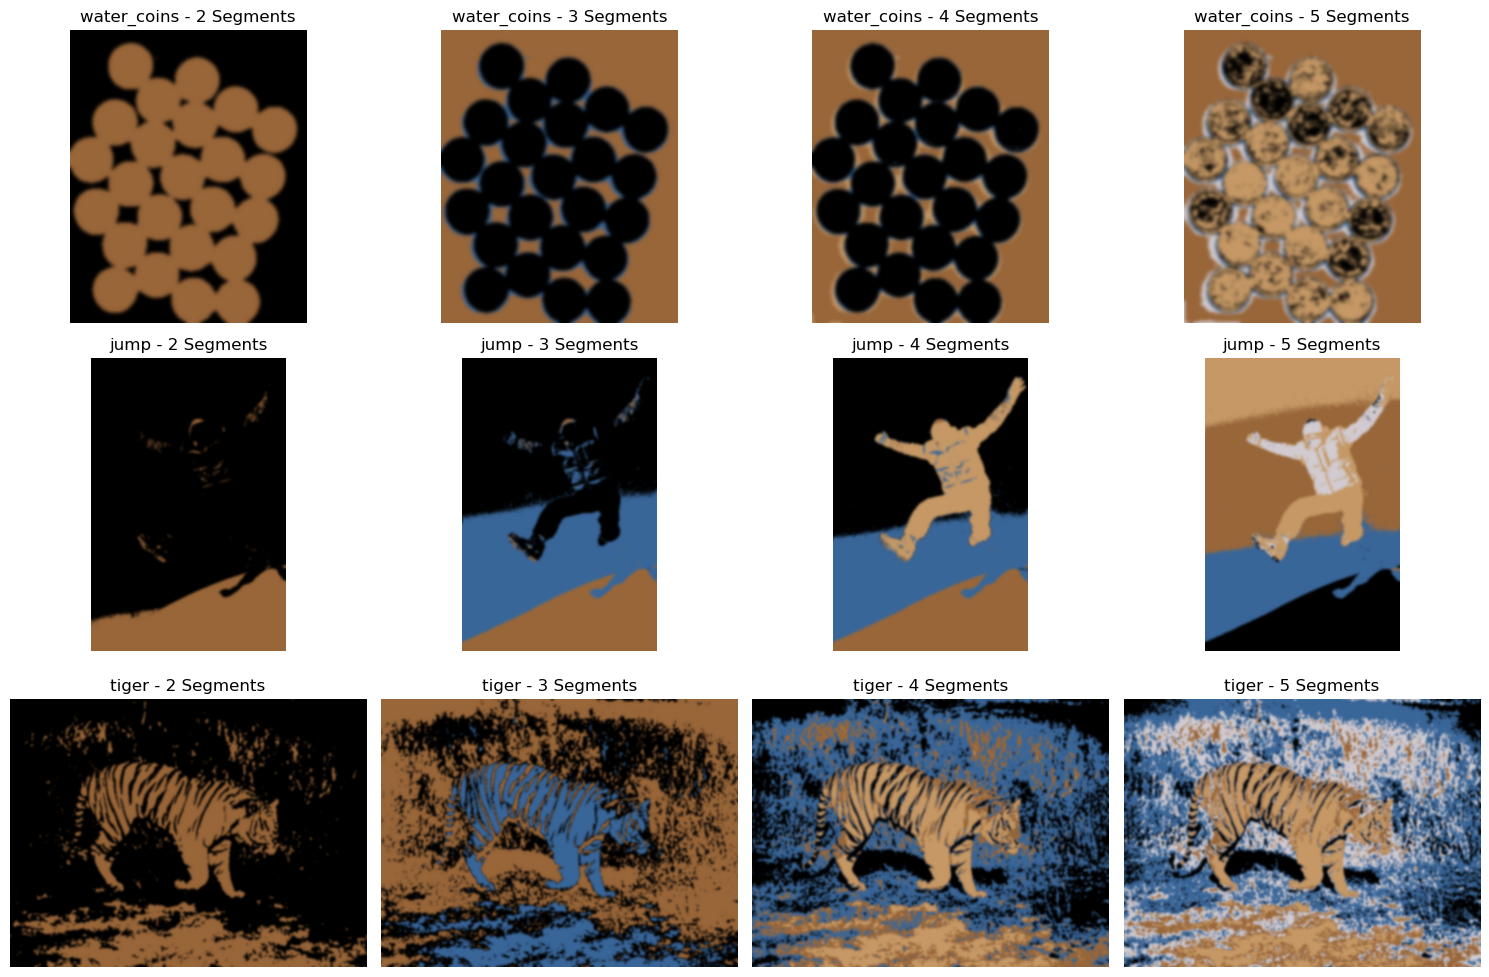

Figure saved to Output/convergence_results.png


In [13]:
""" Display the 20th iteration (or final output in case of convergence) segmentation images 
    with nSegments = 2,3,4,5 for the three images-- this will be a 3 row X 4 column image matrix-- 15 points """  

# Creating a 3x4 subplot layout with a 15 by 10 figure size
fig, axs = plt.subplots(3, 4, figsize=(15, 10))

# Ensuring the output directory exists
os.makedirs('Output', exist_ok=True)

# Loop through each image and segmentation count
for i, imgName in enumerate(imgNames):
    for j, segCount in enumerate(segmentCounts):
        outputPath = join('Output', f'{segCount}_segments', imgName.split('.')[0])  
    
        if os.path.isdir(outputPath):
            # Get all the segmentation files in the directory
            segment_files = sorted([f for f in os.listdir(outputPath) if f.endswith('.png')], key=lambda x: int(x.split('.')[0]))
            
            # Select the 20th or the last file if fewer than 20
            selected_file = segment_files[min(19, len(segment_files)-1)] if segment_files else None

            # Display the image if it exists
            if selected_file:
                img_path = join(outputPath, selected_file)
                img = mpimg.imread(img_path)
                axs[i, j].imshow(img)
                axs[i, j].axis('off')
                axs[i, j].set_title(f'{imgName} - {segCount} Segments')
            
            # Display the error for particular image, if image doesn't exist
            else:
                axs[i, j].text(0.5, 0.5, 'Image not available', ha='center')
                axs[i, j].axis('off')
        else:
            axs[i, j].text(0.5, 0.5, 'Directory not found', ha='center')
            axs[i, j].axis('off')

plt.tight_layout()
plt.show()

# Save the figure
output_figure_path = join('Output', 'convergence_results.png')
fig.savefig(output_figure_path)
print(f"Figure saved to {output_figure_path}")